In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdd-cup-1999-data/kddcup.data.gz
/kaggle/input/kdd-cup-1999-data/training_attack_types
/kaggle/input/kdd-cup-1999-data/kddcup.data.corrected
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled.gz
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled.gz
/kaggle/input/kdd-cup-1999-data/corrected.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.names
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected
/kaggle/input/kdd-cup-1999-data/typo-correction.txt
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data/kddcup.data
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled
/kaggle/input/kdd-cup-1999-data/corrected/corrected
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled/kd

# KDD-Federated-IDS (with accuracy)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, Reshape, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess data
cols = """duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,
num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,
num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,
rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,
dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,
dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate"""

columns = [col.strip() for col in cols.split(',') if col.strip()]
columns.append('target')

# Path to dataset
path = "/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz"
df = pd.read_csv(path, names=columns)


In [3]:
df.shape

(494021, 42)

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
display(df.describe())

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [7]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [8]:
num_cols = df._get_numeric_data().columns
cate_cols = list(set(df.columns)-set(num_cols))
# cate_cols.remove('target')
cate_cols

['service', 'flag', 'target', 'protocol_type']

In [9]:
#Visualization
def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")
    plt.xlabel(feature, fontsize=12)  # Y-axis label
    plt.ylabel("Count", fontsize=12)  # Y-axis label
    plt.title(f"Distribution of {feature}", fontsize=12, fontweight="bold")  # Plot title
    plt.show()  # Display the plot

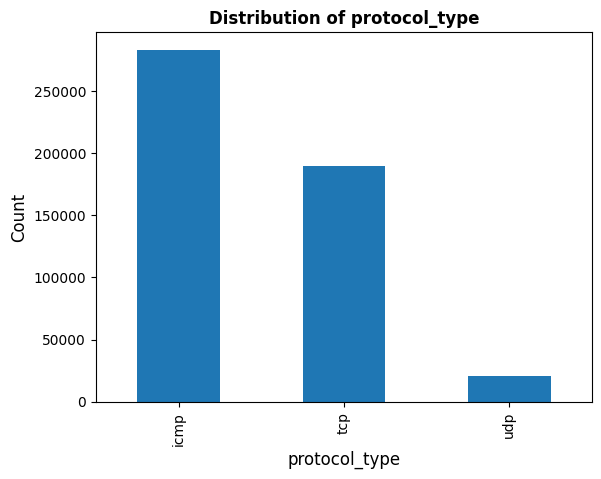

In [10]:
bar_graph('protocol_type')

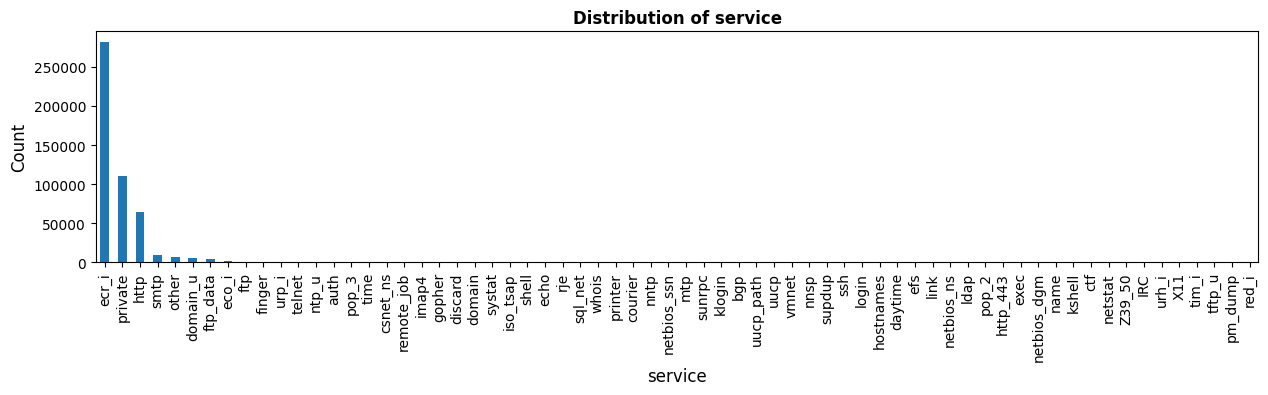

In [11]:
plt.figure(figsize=(15,3))
bar_graph('service')

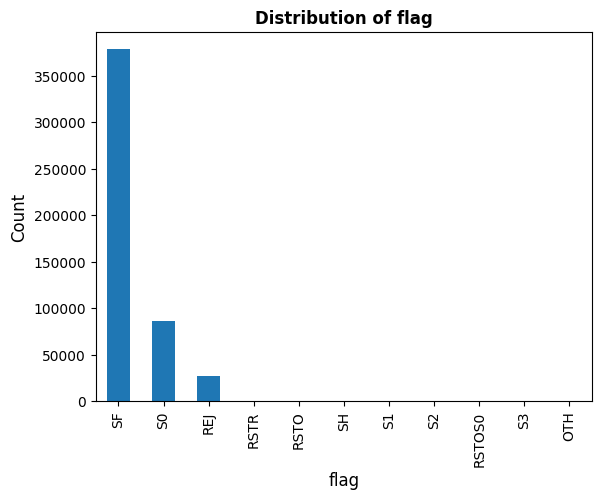

In [12]:
bar_graph('flag')

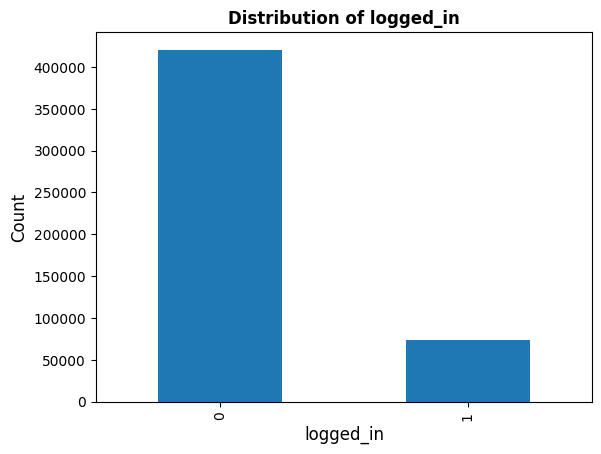

In [13]:
bar_graph('logged_in')

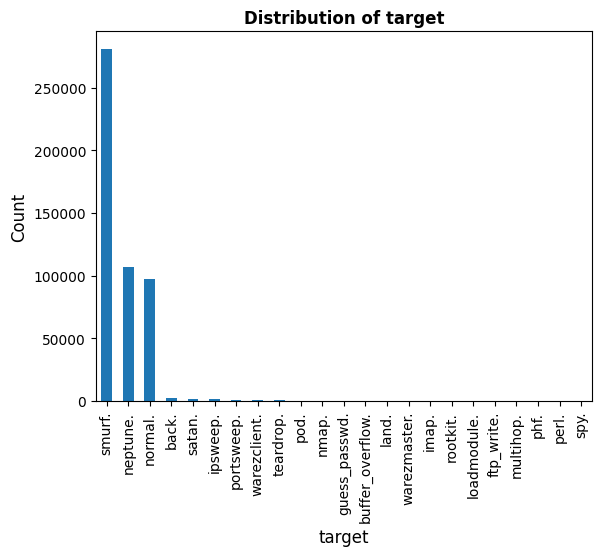

In [14]:
bar_graph('target')

In [15]:
# Feature encoding
# df['protocol_type'] = df['protocol_type'].map({'icmp': 0, 'tcp': 1, 'udp': 2})
# df['flag'] = df['flag'].map({'SF': 0, 'S0': 1, 'REJ': 2, 'RSTR': 3, 'RSTO': 4, 'SH': 5, 'S1': 6, 'S2': 7, 'RSTOS0': 8, 'S3': 9, 'OTH': 10})
label_enc = LabelEncoder()
df['protocol_type'] = label_enc.fit_transform(df['protocol_type'])
df['service'] = label_enc.fit_transform(df['service'])
df['flag'] = label_enc.fit_transform(df['flag'])


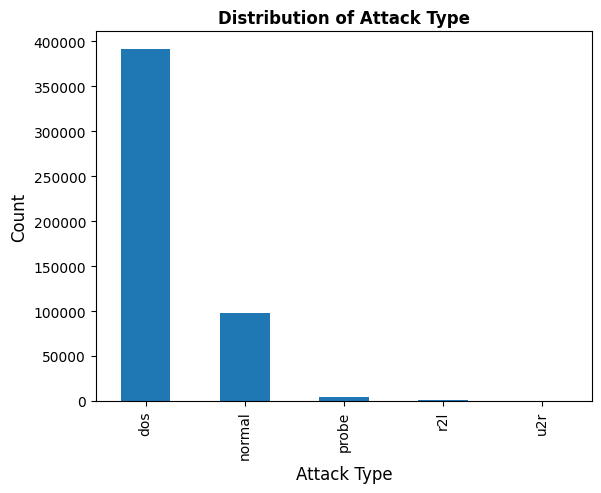

In [16]:
# Attack types mapping
attacks_types = {
    'normal': 'normal', 'back': 'dos', 'buffer_overflow': 'u2r', 'ftp_write': 'r2l', 'guess_passwd': 'r2l',
    'imap': 'r2l', 'ipsweep': 'probe', 'land': 'dos', 'loadmodule': 'u2r', 'multihop': 'r2l', 'neptune': 'dos',
    'nmap': 'probe', 'perl': 'u2r', 'phf': 'r2l', 'pod': 'dos', 'portsweep': 'probe', 'rootkit': 'u2r', 
    'satan': 'probe','smurf': 'dos', 'spy': 'r2l', 'teardrop': 'dos', 'warezclient': 'r2l', 
    'warezmaster': 'r2l'
}
# map target(expected output) column & create a new column
df['Attack Type'] = df.target.apply(lambda r: attacks_types[r[:-1]])
# delete target column
df.drop('target', axis=1, inplace=True)
bar_graph('Attack Type')



## Split df to X and y_encoded

In [17]:
# df.drop('service', axis=1, inplace=True)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['Attack Type'])

print( np.unique(y_encoded) )
print(le.inverse_transform(np.unique(y_encoded)))

# df['Attack Type'] = le.fit_transform(df['Attack Type'])
# y = df[['Attack Type']]
X = df.drop(['Attack Type'], axis=1)
df = []

[0 1 2 3 4]
['dos' 'normal' 'probe' 'r2l' 'u2r']


## Correlation Matrix

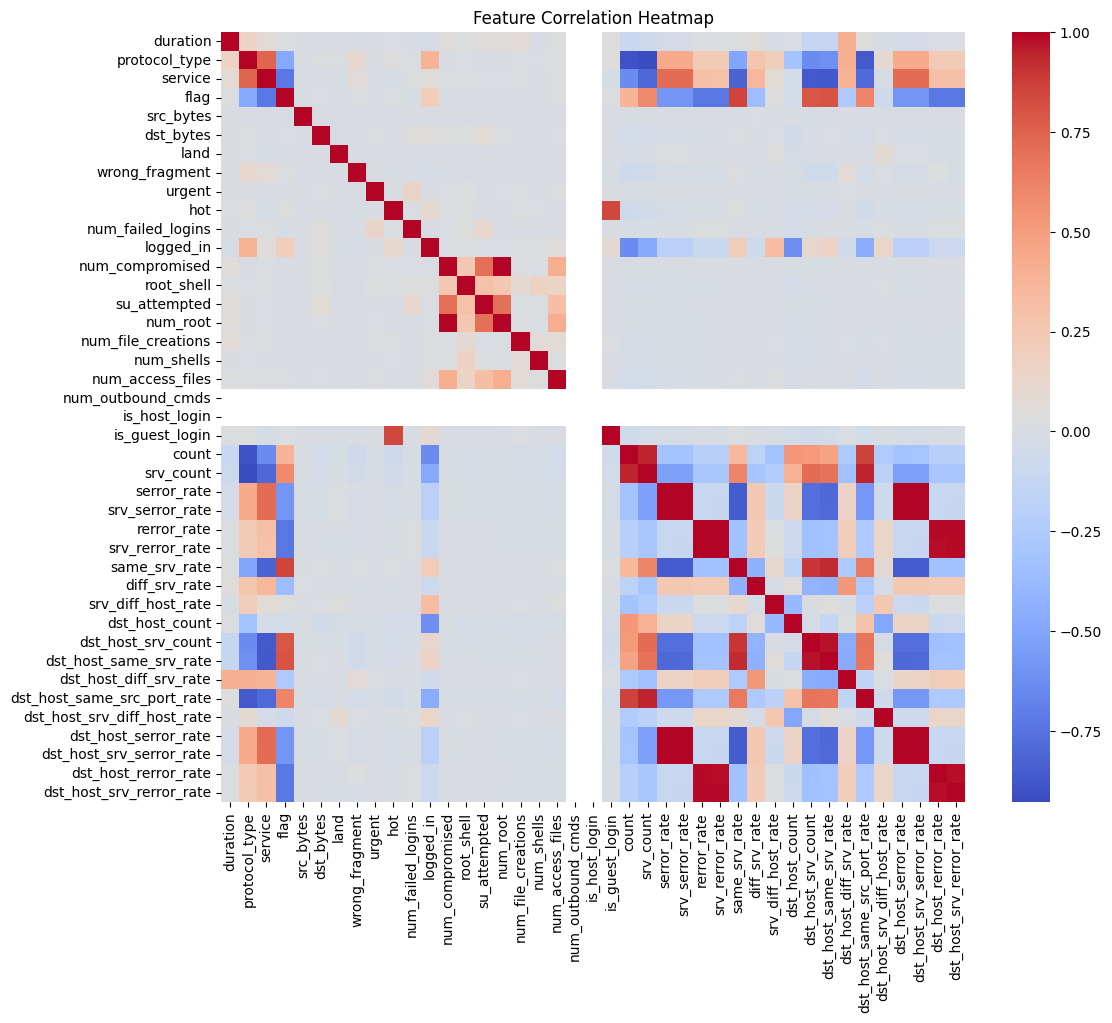


Highly Correlated Features (>|0.95|):
                Feature 1                 Feature 2  Correlation
633       srv_serror_rate  dst_host_srv_serror_rate     0.999304
617           serror_rate      dst_host_serror_rate     0.998673
605           serror_rate           srv_serror_rate     0.998362
735  dst_host_serror_rate  dst_host_srv_serror_rate     0.998156
618           serror_rate  dst_host_srv_serror_rate     0.997849
632       srv_serror_rate      dst_host_serror_rate     0.997835
636           rerror_rate           srv_rerror_rate     0.994731
392       num_compromised                  num_root     0.993828
648           rerror_rate      dst_host_rerror_rate     0.986995
662       srv_rerror_rate  dst_host_srv_rerror_rate     0.986571
649           rerror_rate  dst_host_srv_rerror_rate     0.985200
740  dst_host_rerror_rate  dst_host_srv_rerror_rate     0.984804
661       srv_rerror_rate      dst_host_rerror_rate     0.982166
705    dst_host_srv_count    dst_host_same_srv_rate

In [18]:
# corr_matrix = X.corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, cmap='coolwarm')
# plt.show()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Find highly correlated features (absolute correlation > 0.95)
threshold = 0.95
high_corr = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1) > 0)  # Upper triangle without diagonal
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Filter and sort correlations above threshold
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > threshold].sort_values(by="Correlation", ascending=False)

# Display highly correlated features
print("\nHighly Correlated Features (>|0.95|):")
print(high_corr_pairs)

# 🔹 Identify columns to drop (keep only one per correlated pair)
to_drop = set()
for feature1, feature2, _ in high_corr_pairs.itertuples(index=False):
    if feature1 not in to_drop and feature2 not in to_drop:  # Avoid removing both
        to_drop.add(feature2)  # Remove one of the highly correlated columns

# 🔹 Remove highly correlated columns from X
X_cleaned = X.drop(columns=to_drop)

# Print removed columns
print(f"\nDropped {len(to_drop)} highly correlated features:")
for feature in sorted(to_drop):
    print(f"🛑 {feature}")


## Drop Hightly Correlated Columns

In [19]:
# #This variable is highly correlated with num_compromised and should be ignored for analysis.
# #(Correlation = 0.9938277978738366)
# X.drop('num_root',axis = 1,inplace = True)

# #This variable is highly correlated with serror_rate and should be ignored for analysis.
# #(Correlation = 0.9983615072725952)
# X.drop('srv_serror_rate',axis = 1,inplace = True)

# #This variable is highly correlated with rerror_rate and should be ignored for analysis.
# #(Correlation = 0.9947309539817937)
# X.drop('srv_rerror_rate',axis = 1, inplace=True)

# #This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
# #(Correlation = 0.9993041091850098)
# X.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)

# #This variable is highly correlated with rerror_rate and should be ignored for analysis.
# #(Correlation = 0.9869947924956001)
# X.drop('dst_host_serror_rate',axis = 1, inplace=True)

# #This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
# #(Correlation = 0.9821663427308375)
# X.drop('dst_host_rerror_rate',axis = 1, inplace=True)

# #This variable is highly correlated with rerror_rate and should be ignored for analysis.
# #(Correlation = 0.9851995540751249)
# X.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)

# #This variable is highly correlated with dst_host_srv_count and should be ignored for analysis.
# #(Correlation = 0.9736854572953938)
# X.drop('dst_host_same_srv_rate',axis = 1, inplace=True)

In [20]:
X.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [21]:
X.shape

(494021, 41)

## Scale features

In [22]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split Data Across Clients

In [23]:
def split_data(x, y, num_clients):
    client_data = []
    shard_size = len(x) // num_clients
    for i in range(num_clients):
        start = i * shard_size
        end = start + shard_size
        client_data.append((x[start:end], y[start:end]))
    return client_data


# Define Model

In [24]:

def create_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(256)(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    lstm_input = Reshape((256, 1))(x)
    lstm_out = LSTM(128, return_sequences=False)(lstm_input)
    
    cnn_input = Reshape((256, 1))(x)
    cnn_out = Conv1D(64, 3, activation="relu")(cnn_input)
    cnn_out = Flatten()(cnn_out)
    
    merged = concatenate([lstm_out, cnn_out, x])
    merged = Dense(64)(merged)
    merged = LeakyReLU()(merged)
    merged = Dropout(0.3)(merged)
    output_layer = Dense(1, activation="sigmoid")(merged)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    return model



# Federated Learning Training

In [25]:
def Federated_Learning_Training(X_tv, y_tv,X_test,y_test, num_clients=3, num_rounds=10,epochs=1, batch_size=32):
    # Split data for 3 clients
    # num_clients = 3
    client_data = split_data(X_tv, y_tv, num_clients)

    input_dim = X_tv.shape[1]

    # Initialize the global model
    global_model = create_model(input_dim)
    # Each local model starts with the same initial weights
    initial_weights = global_model.get_weights()

    # Number of rounds for federated learning
    # num_rounds = 15
    for round_num in range(num_rounds):
        print(f"Round {round_num + 1}/{num_rounds}")
    
        local_weights = []
    
        # Train on each client
        for client_id in range(num_clients):
            print(f"Training on client {client_id + 1}")
    
            # Create local model and set global weights
            local_model = create_model(input_dim)
            local_model.set_weights(global_model.get_weights())
    
            # Get client data
            X, y = client_data[client_id]
    
            # Train local model
            # local_model.fit(X, y, epochs=1, batch_size=32, verbose=0)
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

            lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
            early_stopping = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    
            local_model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1,
                callbacks=[lr_scheduler, early_stopping]
            )
    
            # Collect local model weights
            local_weights.append(local_model.get_weights())
    
        # Federated averaging: Aggregate local weights
        averaged_weights = [np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
                            for i in range(len(local_weights[0]))]
    
        # Update global model weights
        global_model.set_weights(averaged_weights)
    
        # Evaluate the global model
        loss, accuracy = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Global model accuracy after round {round_num + 1}: {accuracy:.4f}")

        return global_model



# ---------------------------------------------------------------------
# Split data
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
final_model = Federated_Learning_Training(X_train_validate, y_train_validate, X_test, y_test,3, 20, 5)

Round 1/20
Training on client 1
Epoch 1/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9705 - loss: -6.0455 - val_accuracy: 0.9811 - val_loss: -124.3204 - learning_rate: 1.0000e-04
Epoch 2/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.9712 - loss: -201.5877 - val_accuracy: 0.9816 - val_loss: -1179.6969 - learning_rate: 1.0000e-04
Epoch 3/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.9705 - loss: -1131.4904 - val_accuracy: 0.9820 - val_loss: -4571.3086 - learning_rate: 1.0000e-04
Epoch 4/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.9699 - loss: -3776.1443 - val_accuracy: 0.9817 - val_loss: -12797.5176 - learning_rate: 1.0000e-04
Epoch 5/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.9681 - loss: -10125.4971 - val_accuracy: 0.9820 - val_loss: -28560.9453 - learning_rate: 1.0000e-04
Training on client 2
Epoch 1/5
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - accuracy: 0.9687 - loss: -6.3778 - val_accuracy: 0.9818 -

## Show Accuracy, Classification Report, Confusion Matrix

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
Accuracy: 98.14%

Classification Report:
              precision    recall  f1-score       support
dos            0.998241  0.992304  0.995264  78355.000000
normal         0.918723  0.992921  0.954382  19353.000000
probe          1.000000  0.000000  0.000000    850.000000
r2l            1.000000  0.000000  0.000000    235.000000
u2r            1.000000  0.000000  0.000000     12.000000
accuracy       0.981408  0.981408  0.981408      0.981408
macro avg      0.983393  0.397045  0.389929  98805.000000
weighted avg   0.982685  0.981408  0.976206  98805.000000


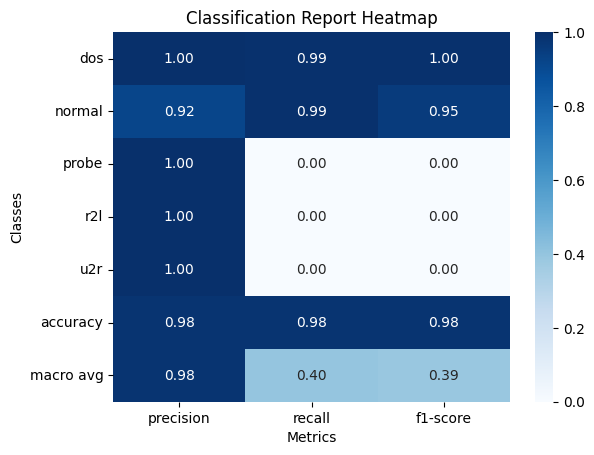


Confusion Matrix:


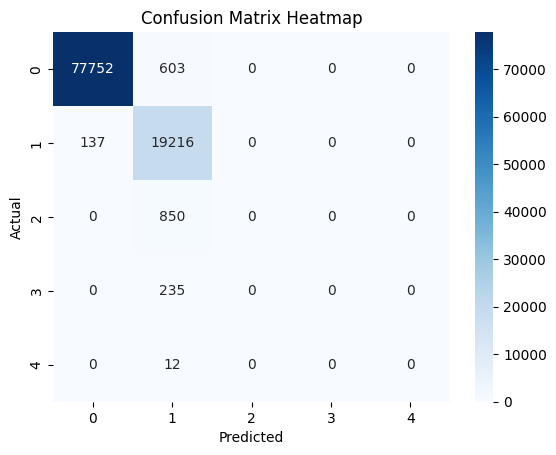

In [26]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Ensure `final_model` is trained and valid before predicting
if final_model is not None:
    # 🔹 Get model predictions
    y_prob = final_model.predict(X_test)  # Probabilities
    y_pred = (y_prob > 0.5).astype(int).flatten()  # Convert to binary labels

    # 🔹 Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Decode the predictions and true labels to attack types
    decoded_y_test = le.inverse_transform(y_test)
    decoded_y_pred = le.inverse_transform(y_pred)
    # 🔹 Classification Report with `zero_division=1`
    report = classification_report(decoded_y_test, decoded_y_pred, output_dict=True, zero_division=1)
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(report_df)

    # 🔹 Classification Report Heatmap
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title("Classification Report Heatmap")
    plt.ylabel("Classes")
    plt.xlabel("Metrics")
    plt.show()

    # 🔹 Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(decoded_y_test, decoded_y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix Heatmap")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
else:
    print("Error: Model training failed. `final_model` is None.")


## Show Model Summary

In [27]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, Reshape, concatenate
from tensorflow.keras.optimizers import Adam


# Create model with an example input dimension
input_dim = X_test.shape[1]  # Change based on your actual input features
model = create_model(input_dim)

# Generate and save model diagram
plot_model(model, to_file="model_diagram.png", show_shapes=True, show_layer_names=True)

# Display the model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 41)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     10,752 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 256)       │          0 │ dense_12[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_8[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 256, 1)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 256, 1)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 254, 64)   │        256 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │     66,560 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 16256)     │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16640)     │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │  1,065,024 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,143,681 (4.36 MB)

 Trainable params: 1,143,169 (4.36 MB)

 Non-trainable params: 512 (2.00 KB)

## Show Model Diagram

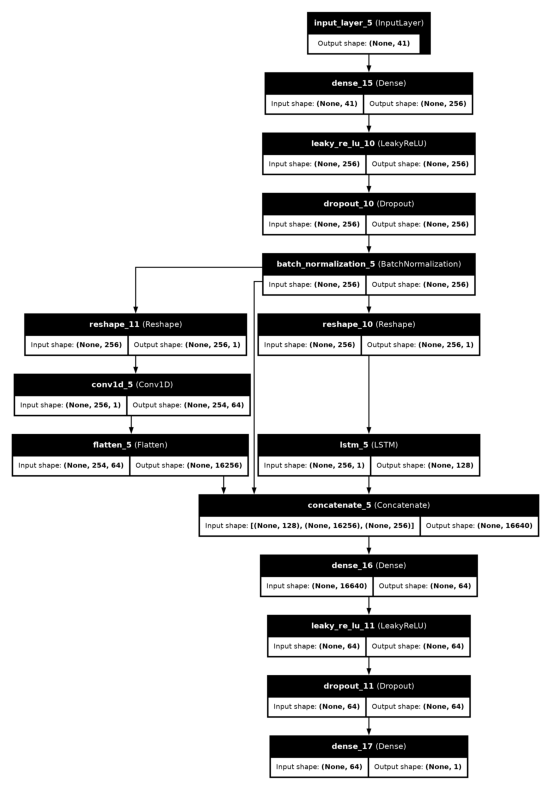

In [28]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2  # Required to display the saved image

# Define input dimension
input_dim = 41  # Adjust based on your dataset

# Create the model
model = create_model(input_dim)

# Generate and save model diagram
plot_model(model, to_file="model_diagram.png", show_shapes=True, show_layer_names=True, dpi=150)

# Load and display the saved image
img = cv2.imread("/kaggle/working/model_diagram.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper color display

# Plot the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()
